In [90]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import collections
import copy
from pprint import pprint
from typing import List

import numpy as np
import torch as th
import torch.nn.functional as thf

from rl.algs import environment
from rl.algs import model
from rl.algs import util



Sars = collections.namedtuple('Sars', 's a r s1')

class ReplayBuffer:
  def __init__(self, size=1000000):
    self.buf = [None] * size
    self.i = 0
    self.size = 0
    self.max_size = size

  def add(self, entry):
    self.buf[self.i] = entry
    self.i = (self.i + 1) % self.max_size
    if self.size < self.max_size:
      self.size += 1

  def sample(self, n=1):
    """Samples n entries uniformly at random, without replacement."""
    assert n <= self.size
    idxs = np.random.choice(self.size, n, replace=False)
    entries = [self.buf[i] for i in idxs]
    return entries


class Dqn:
  def __init__(self, model, lr):
    self.model = model
    self.target_model = copy.deepcopy(self.model)
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
    self.eps = 0.5  # TODO: anneal this
    self.gamma = 0.99

  def action_values(self, obs_np):
    obs_var = util.to_variable(obs_np)
    return self.model(obs_var)
  
  def get_action(self, obs_np):
    qs = self.action_values(obs_np)
    probs = thf.softmax(qs, dim=-1)
    probs = util.to_numpy(probs)
    return util.sample_eps_greedy(probs, self.eps)

  def update(self, sars_batch: List[Sars]):
    bs = len(sars_batch)
    empty = np.zeros_like(sars_batch[0].s)
    s_batch = np.stack([sars.s for sars in sars_batch])
    a_batch = np.stack([sars.a for sars in sars_batch])
    r_batch = util.to_variable(np.stack([sars.r for sars in sars_batch]))
    s1_batch = np.stack([sars.s1 if sars.s1 is not None else empty
                         for sars in sars_batch])
    
    terminal_mask = util.to_variable(
        np.stack([1 if sars.s1 is None else 0 for sars in sars_batch]))
    
    a_var = util.to_variable(a_batch, dtype=th.LongTensor).unsqueeze(dim=1)
    
    qs = self.action_values(s_batch)
    qs_sel = th.gather(qs, dim=-1, index=a_var)
    
    s1_var = util.to_variable(s1_batch, volatile=True)
    target_qs = self.target_model(s1_var)
    target_qs_max, qs_max_idx = th.max(target_qs, dim=-1)
    target = self.gamma * terminal_mask * target_qs_max
    target += r_batch

    loss = thf.mse_loss(qs_sel, target)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    


/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(4, 84, 84)
torch.Size([1, 4, 84, 84])
1
(4, 84, 84)
torch.Size([1, 4, 84, 84])
2
(4, 84, 84)
torch.Size([1, 4, 84, 84])
1
(4, 84, 84)
torch.Size([1, 4, 84, 84])
1


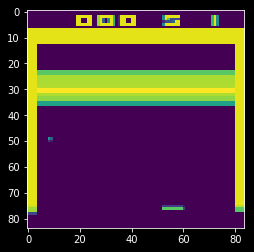

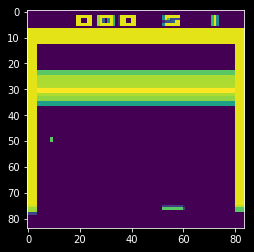

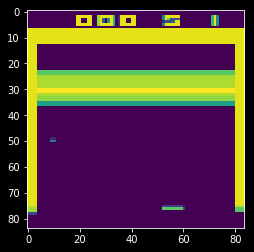

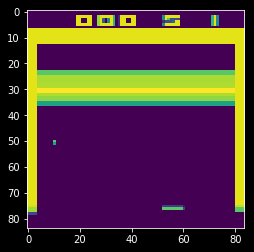

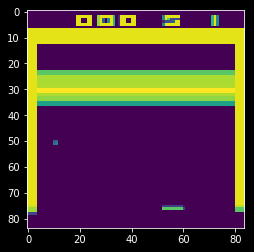

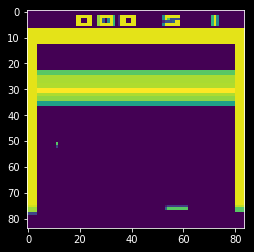

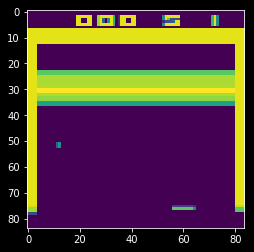

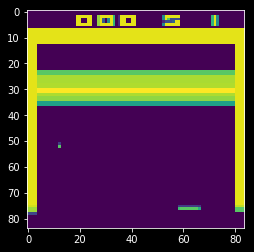

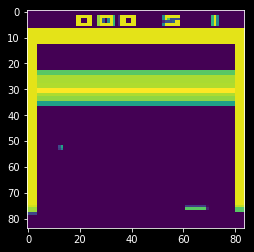

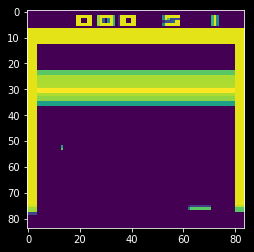

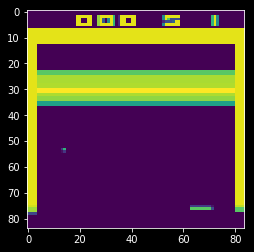

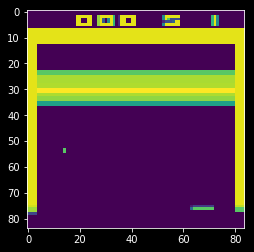

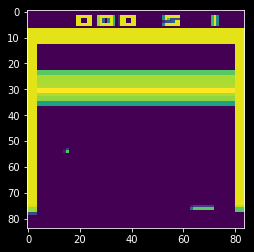

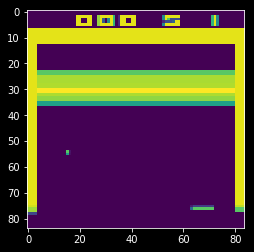

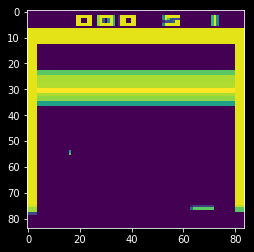

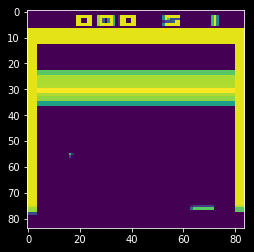

In [139]:
# Train the DQN

from rl.algs import experiment

env = environment.AtariEnvironment('Breakout')
model_params = {
  'hidden_layers': (128, 64,),
}
policy_params = {
  'lr': 0.005,
}
exp = experiment.Experiment(env, model.QNetwork, model_params,
                            Dqn, policy_params)
NUM_TRAIN_STEPS = 4

for step in range(NUM_TRAIN_STEPS):
  sars = env.step(exp.policy.get_action)
  print(sars.a)
  for i in range(4):
    pyplot.figure()
    pyplot.imshow(env.last_obs[i, :, :])

In [61]:
dqn = Dqn()
dqn.get_action(np.random.rand(210))

test_sars = [
    Sars(np.random.rand(210), 3, 0, np.random.rand(210)),
    Sars(np.random.rand(210), 0, 1, None),
    Sars(np.random.rand(210), 2, 2, np.random.rand(210)),
    Sars(np.random.rand(210), 1, 3, None)
]
dqn.update(test_sars)



In [78]:
rb = ReplayBuffer(5)
[rb.add(c) for c in 'abcdef']
print(rb.sample(2))

qs = np.random.rand(5, 4)
actions = np.array([0, 2, 1, 3, 0], dtype=np.int)
pprint(qs)
pprint(actions)
pprint(qs[range(5), actions])
qs[[False, True, True, False, True], :] = 0
pprint(qs)

['f', 'c']
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.30351326, 0.70604155, 0.98818081, 0.04975847],
       [0.43589021, 0.99924586, 0.77265579, 0.15717228],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.07857284, 0.86944281, 0.60107863, 0.9752491 ]])
array([0, 2, 1, 3, 0])
array([0.54102279, 0.98818081, 0.99924586, 0.37340199, 0.07857284])
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.        , 0.        , 0.        , 0.        ]])


In [104]:
from skimage import color
rgb = np.zeros((2, 1, 3))
rgb[1, 0, :] = 1
color.rgb2yuv(rgb)[:, :, 0]

array([[0.],
       [1.]])